In [1]:
using LCIO
using GRUtils
using FastJet
using CxxWrap: StdVector

In [2]:
const FILENAME="/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/E250-TDR_ws.Pe2e2h.Gwhizard-1_95.eL.pR.I106479.001.slcio"

"/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/E250-TDR_ws.Pe2e2h.Gwhizard-1_95.eL.pR.I106479.001.slcio"

In [3]:
# simple histograms
jetMassList = Float64[]
nJetList = Float64[]
nParticleList = Float64[]

# We are setting up the jet algorithm
# for details, see "A new jet reconstruction algorithm for lepton colliders"
# https://arxiv.org/abs/1404.4294
vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

FastJet.JetDefinitionAllocated(Ptr{Nothing} @0x00000000026fbb10)

In [16]:
LCIO.open(FILENAME) do reader
    iEvent = 0
    for event in reader
        iEvent += 1
        iParticle = 0
        iMuon = 0
        particles = PseudoJet[]
        for particle in getCollection(event, "MCParticle")
            iParticle += 1
            if getGeneratorStatus(particle) != 1
                continue
            end
            E = getEnergy(particle)
            p = getMomentum(particle)
            # FastJet doesn't operate on LCIO particles, unfortunately. It wants its own input format.
            push!(particles, PseudoJet(p[1], p[2], p[3], E))
        end
        # after preparing the input, we can run the tool
        cs = ClusterSequence(StdVector(particles), jet_def)
        # We want 4 jets. Ideally, we'll have one muon from the Z each in two of the jets
        # and particles corresponding to the strange quarks in the other two.
        # This is the lazy way to do the reconstruction.
        # A better way is to find the muons from the Z _first_, and then hand the rest to the jet finder.
        jets = exclusive_jets(cs, 4)
        push!(nJetList, length(jets))
        for j in jets
            # this is just for demonstration how to figure out what particles are in which jet
            # we have forced the event into four jets, so if we don't get back exactly 4 here, something wrong.
            push!(nParticleList, length(constituents(j)))
            e2 = E(j)^2
            p2 = px(j)^2 - py(j)^2 -pz(j)^2
            m = e2 > p2 ? sqrt(e2 - p2) : 0
            push!(jetMassList, m)
        end
    end
    println("read ", iEvent, " events")
end

read 17143 events


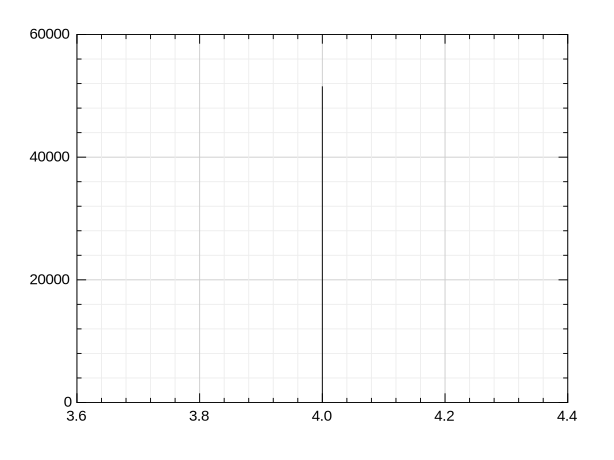

In [17]:
histogram(nJetList)
# savefig("nJets.pdf")

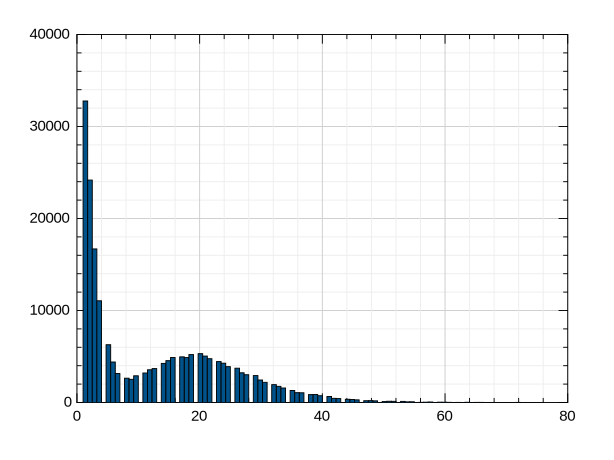

In [18]:
histogram(nParticleList, nbins=100)
# savefig("nParticles.pdf")

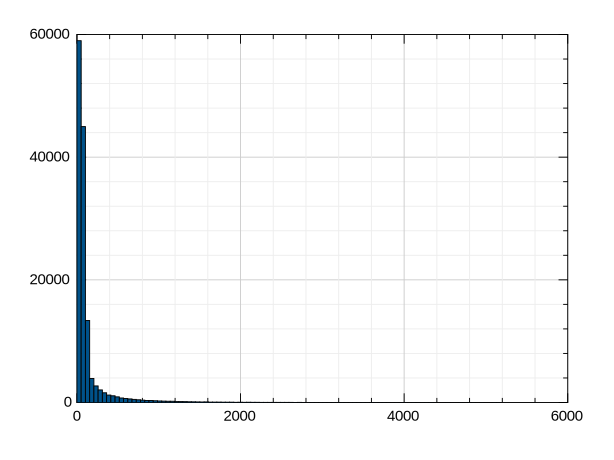

In [19]:
histogram(jetMassList, nbins=100)
# savefig("jetMass.pdf")